In [1]:
import scanpy as scp
import pandas as pd
import numpy as np

In [22]:
bulk_raw = scp.read_h5ad('./data/K562_essential_normalized_bulk_01.h5ad')

In [23]:
bulk_raw.var[bulk_raw.var.gene_name == gene]

,gene_name,mean,std,cv,in_matrix,gini,clean_mean,clean_std,clean_cv
gene_id,,,,,,,,,
ENSG00000110104,CCDC86,0.701475,0.175006,0.249483,True,0.137211,0.749281,0.17782,0.237321


In [60]:
bulk_raw.var

,gene_name,mean,std,cv,in_matrix,gini,clean_mean,clean_std,clean_cv
gene_id,,,,,,,,,
ENSG00000237491,LINC01409,0.130014,0.043734,0.336381,True,0.179845,0.137393,0.046048,0.335153
ENSG00000228794,LINC01128,0.243296,0.064490,0.265067,True,0.142173,0.259054,0.067663,0.261195
ENSG00000188976,NOC2L,1.887061,0.327900,0.173762,True,0.094459,2.005543,0.326936,0.163016
ENSG00000187961,KLHL17,0.114511,0.043057,0.376007,True,0.196132,0.120919,0.043987,0.363770
ENSG00000188290,HES4,0.237708,0.084139,0.353960,True,0.182887,0.251248,0.088138,0.350802
...,...,...,...,...,...,...,...,...,...
ENSG00000278704,BX004987.1,0.227898,0.058213,0.255434,True,0.139306,0.240996,0.060908,0.252734
ENSG00000274847,MAFIP,0.121706,0.042970,0.353064,True,0.186434,0.128235,0.044821,0.349526
ENSG00000278384,AL354822.1,0.233260,0.057251,0.245438,True,0.134192,0.246777,0.060972,0.247074


In [2]:
ss_norm = scp.read_h5ad('./data/K562_essential_normalized_singlecell_01.h5ad')

In [3]:
gene = 'CCDC86'

In [71]:
cells = ss_norm.obs[ss_norm.obs.gene == gene].index

In [ ]:
for c in cells:
    ss_norm[c]

In [61]:
ss_norm['AAACCCAAGAAATCCA-27'].var

,gene_name,chr,start,end,class,strand,length,in_matrix,mean,std,cv,fano
gene_id,,,,,,,,,,,,
ENSG00000237491,LINC01409,chr1,778747,810065,gene_version10,+,31318,True,0.137594,0.380048,2.762105,1.049733
ENSG00000228794,LINC01128,chr1,825138,868202,gene_version9,+,43064,True,0.256720,0.520162,2.026184,1.053944
ENSG00000188976,NOC2L,chr1,944203,959309,gene_version11,-,15106,True,1.975144,1.707837,0.864665,1.476706
ENSG00000187961,KLHL17,chr1,960584,965719,gene_version14,+,5135,True,0.119593,0.353702,2.957540,1.046089
ENSG00000188290,HES4,chr1,998962,1000172,gene_version10,-,1210,True,0.249577,0.561933,2.251540,1.265214
...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000278704,BX004987.1,GL000009.2,56140,58376,gene_version1,-,2236,True,0.241213,0.507266,2.102976,1.066768
ENSG00000274847,MAFIP,GL000194.1,53594,115055,gene_version1,-,61461,True,0.127525,0.361556,2.835168,1.025072
ENSG00000278384,AL354822.1,GL000218.1,51867,54893,gene_version1,-,3026,True,0.248814,0.516552,2.076062,1.072394


In [47]:
ss_norm.var.h

,gene_name,chr,start,end,class,strand,length,in_matrix,mean,std,cv,fano
gene_id,,,,,,,,,,,,
ENSG00000237491,LINC01409,chr1,778747,810065,gene_version10,+,31318,True,0.137594,0.380048,2.762105,1.049733
ENSG00000228794,LINC01128,chr1,825138,868202,gene_version9,+,43064,True,0.256720,0.520162,2.026184,1.053944
ENSG00000188976,NOC2L,chr1,944203,959309,gene_version11,-,15106,True,1.975144,1.707837,0.864665,1.476706


In [55]:
ss_norm['AAACCCAAGAAATCCA-27']

View of AnnData object with n_obs × n_vars = 1 × 8563
    obs: 'gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor', 'core_adjusted_UMI_count'
    var: 'gene_name', 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano'

<Axes: ylabel='Frequency'>

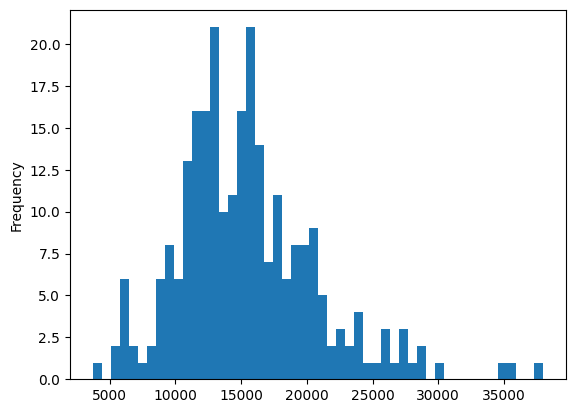

In [25]:
ss_norm.obs[ss_norm.obs.gene == gene].core_adjusted_UMI_count.plot.hist(bins=50)

In [18]:
ss_norm.var.columns

Index(['gene_name', 'chr', 'start', 'end', 'class', 'strand', 'length',
       'in_matrix', 'mean', 'std', 'cv', 'fano'],
      dtype='object')